<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/Two_finger_neural_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility Functions

---



In [1]:
def bin_spikes(spikes, bin_size):

    """
    Bin spikes in time.

    Inputs
    ------
    spikes: numpy array of spikes (neurons x time)

    bin_size: number of time points to pool into a time bin

    Outputs
    -------
    S: numpy array of spike counts (neurons x bins)

    """

    # Get some useful constants.
    [N, n_time_samples] = spikes.shape
    K = int(n_time_samples/bin_size) # number of time bins

    # Count spikes in bins.
    S = np.empty([N, K])
    for k in range(K):
        S[:, k] = np.sum(spikes[:, k*bin_size:(k+1)*bin_size], axis=1)

    return S


# Neural Decoders

---



Kalman Filter

---



In [2]:
######-------------------------------- Konrad Kording's Version ----------------------------------------#########



class KalmanFilterDecoder_PIS(object):

    """
    Class for the Kalman Filter Decoder with precomputed initial state

    Parameters
    -----------
    C - float, optional, default 1
    This parameter scales the noise matrix associated with the transition in kinematic states.
    It effectively allows changing the weight of the new neural evidence in the current update.

    Our implementation of the Kalman filter for neural decoding is based on that of Wu et al 2003 (https://papers.nips.cc/paper/2178-neural-decoding-of-cursor-motion-using-a-kalman-filter.pdf)
    with the exception of the addition of the parameter C.
    The original implementation has previously been coded in Matlab by Dan Morris (http://dmorris.net/projects/neural_decoding.html#code)
    """

    def __init__(self,C=1):
        self.C=C

    def fit(self, X_kf_train, y_train):
        """
        Train Kalman Filter Decoder

        Parameters
        ----------
        X_kf_train: numpy 2d array of shape [n_samples , n_neurons]
        y_train: numpy 2d array of shape [n_samples, n_outputs]
        """

        X = np.matrix(y_train.T)
        Z = np.matrix(X_kf_train.T)
        nt = X.shape[1]

        # State transition matrix (A) and process noise (W)
        X2 = X[:,1:]
        X1 = X[:,0:nt-1]
        A = X2 * X1.T * inv(X1 * X1.T)
        W = (X2 - A * X1) * (X2 - A * X1).T / (nt-1) / self.C

        # Observation matrix (H) and measurement noise (Q)
        H = Z * X.T * inv(X * X.T)
        Q = (Z - H * X) * (Z - H * X).T / nt

        # === Precompute initial state ===
        # Get initial states (columns) across sequences
        # Here, assuming y_train is continuous, so we extract first point only
        z0 = np.mean(X[:, 0], axis=1)         # shape: [n_outputs x 1]
        P0 = np.cov(X[:, 0]) if X.shape[1] > 1 else np.eye(X.shape[0])  # fallback if single point

        self.model = {
            'A': A,
            'W': W,
            'H': H,
            'Q': Q,
            'z0': z0,
            'P0': P0
        }

    def predict(self, X_kf_test, y_test=None):
        """
        Predict outcomes using trained Kalman Filter Decoder

        Parameters
        ----------
        X_kf_test: numpy 2d array of shape [n_samples , n_neurons]
        y_test: unused if z0 is available
            Kept for backward compatibility

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples, n_outputs]
        """

        A = self.model['A']
        W = self.model['W']
        H = self.model['H']
        Q = self.model['Q']
        z0 = self.model['z0']
        P0 = self.model['P0']

        Z = np.matrix(X_kf_test.T)
        num_states = A.shape[0]
        num_timesteps = Z.shape[1]

        states = np.empty((num_states, num_timesteps))
        P = np.matrix(P0)
        state = z0.copy()
        states[:, 0] = np.squeeze(state)

        for t in range(num_timesteps - 1):
            # Time update
            P_m = A * P * A.T + W
            state_m = A * state

            # Measurement update
            K = P_m * H.T * inv(H * P_m * H.T + Q)
            P = (np.matrix(np.eye(num_states)) - K * H) * P_m
            state = state_m + K * (Z[:, t+1] - H * state_m)
            states[:, t+1] = np.squeeze(state)

        y_test_predicted = states.T
        return y_test_predicted


######-------------------------------- Sean Perkins' Version ----------------------------------------#########

import numpy as np
from numpy.linalg import inv, pinv
from scipy.linalg import solve_discrete_are
import warnings

class KalmanFilter(object):

    """
    Class for the Kalman filter decoder

    Hyperparameters
    ---------------
    Delta: number of time points to pool into a time bin

    lag: number of time samples to lag behavioral variables relative to spiking data
        This accounts for the physiological latency between when neurons become active
        and when that activity impacts behavior.

    steady_state: boolean determining whether the steady-state form of the Kalman filter should be used
        The steady-state Kalman filter is much faster for prediction, but takes
        a few samples to converge to the same output as the standard Kalman filter.

    """

    def __init__(self,HyperParams):
        self.Delta = HyperParams['Delta']
        self.lag = HyperParams['lag']
        self.bin_lag = int(np.round(self.lag / self.Delta))
        self.Ts = .001 # hardcodes sampling period at 1 ms
        self.dt = self.Delta * self.Ts
        self.steady_state = HyperParams['steady_state']

    def fit(self, S, Z):

        """
        Train Kalman filter.

        Inputs
        ------
        S: list of N x T numpy arrays, each of which contains spiking data for N neurons over T times

        Z: list of 4 x T numpy arrays, each of which contains behavioral data for position and velocity
            The first two rows correspond to x- and y-position
            The last two rows correspond to x- and y-velocity

        Parameters (Steady-state Kalman filter)
        ----------
        A: state-transition matrix (7 x 7 numpy array)
        C: observation matrix (N x 7 numpy array)
        K_inf: steady-state Kalman gain (7 x N numpy array)
        z0: initial state mean (7 x 1 numpy 1D array)

        Parameters (Standard Kalman filter)
        ----------
        A: state-transition matrix (7 x 7 numpy array)
        C: observation matrix (N x 7 numpy array)
        Q: state-transition noise covariance (7 x 7 numpy array)
        R: observation noise covariance (N x N numpy array)
        z0: initial state mean (7 x 1 numpy 1D array)
        P0: initial state covariance (7 x 7 numpy array)

        """

        # Unpack attributes.
        Delta = self.Delta
        lag   = self.lag
        dt    = self.dt

        # Shift data to account for lag.
        if self.lag > 0:
            S = [s[:,:-lag] for s in S]
            Z = [z[:,lag:] for z in Z]

        # Compute acceleration. We are assuming that the first two components of Z are something
        # akin to position and the second two components are the something akin to velocity.
        acc = [np.hstack((np.zeros((2,1)),np.diff(z[2:4,:],axis=1)/self.Ts)) for z in Z]
        Z = [np.vstack((z,a)) for z,a in zip(Z,acc)]

        # Add a row of ones to allow for constant offset.
        Z = [np.vstack((z,np.ones(z.shape[1]))) for z in Z]

        # Downsample kinematics.
        Z = [z[:,Delta-1::Delta] for z in Z]

        # Bin spikes.
        S = [bin_spikes(sp, Delta) for sp in S]

        # Convert lists (one entry per trial) to large arrays.
        Z_init = np.concatenate([np.reshape(z[:,0], (-1, 1)) for z in Z], axis=1)
        Z1 = np.concatenate([z[:,:-1] for z in Z], axis=1)
        Z2 = np.concatenate([z[:,1:] for z in Z], axis=1)
        Z = np.concatenate(Z, axis=1)
        S = np.concatenate(S, axis=1)

        # Fit state transition matrix.
        A = Z2 @ Z1.T @ inv(Z1 @ Z1.T)

        # Fit measurement matrix.
        C = S @ Z.T @ inv(Z @ Z.T)

        # Fit state noise covariance.
        T1 = Z1.shape[1]
        Q = ((Z2 - A @ Z1) @ (Z2 - A @ Z1).T) / T1

        # Fit measurement noise covariance.
        T2 = Z.shape[1]
        R = ((S - C @ Z) @ (S - C @ Z).T) / T2

        # Fit initial state
        z0 = np.mean(Z_init, axis=1)
        P0 = np.cov(Z_init, bias=True)

        # Store parameters appropriate for standard or steady-state Kalman filter.
        if self.steady_state:

            try:
                # Compute steady-state Kalman gain.
                Q = (Q + Q.T)/2 # ensures Q isn't slightly asymmetric due to floating point errors before running 'dare'
                R = (R + R.T)/2 # ensures R isn't slightly asymmetric due to floating point errors before running 'dare'
                P_inf = solve_discrete_are(A.T,C.T,Q,R)
                K_inf = P_inf @ C.T @ pinv(C @ P_inf @ C.T + R)

                # Store parameters for steady-state Kalman filter.
                self.A = A
                self.C = C
                self.K_inf = K_inf
                self.z0 = z0

            except np.linalg.LinAlgError:

                # The 'solve_discrete_are' function won't always succeed due
                # to numerical properties of the matrices that get fed into
                # it. When it fails, issue a warning to the user letting them
                # know we'll have to revert to the standard Kalman filter.
                warn_str = '''
                Discrete-time algebraic Riccati equation could not be solved using the learned parameters.
                Reverting from steady-state Kalman filter back to standard Kalman filter.'''
                warnings.warn(warn_str)

                # Revert to standard Kalman filter.
                self.steady_state = False
                self.A = A
                self.C = C
                self.Q = Q
                self.R = R
                self.z0 = z0
                self.P0 = P0

        else:

            # Store parameters for standard Kalman filter.
            self.A = A
            self.C = C
            self.Q = Q
            self.R = R
            self.z0 = z0
            self.P0 = P0

    def predict(self, S):

        """
        Predict behavior with trained Kalman filter.

        Inputs
        ------
        S: list of N x T numpy arrays, each of which contains spiking data for N neurons over T times

        Outputs
        -------
        Z_hat: list of 4 x T numpy arrays, each of which contains decoded position and velocity
            The first two rows correspond to x- and y-position estimates
            The last two rows correspond to x- and y-velocity estimates

        """

        # Unpack attributes.
        Delta = self.Delta
        bin_lag = self.bin_lag
        A = self.A
        C = self.C
        z0 = self.z0
        if self.steady_state:
            K_inf = self.K_inf
        else:
            Q = self.Q
            R = self.R
            P0 = self.P0

        # Compute trial lengths.
        T = [s.shape[1] for s in S]

        # Bin spikes.
        S = [bin_spikes(sp, Delta) for sp in S]

        # Create estimates for each trial.
        n_trials = len(S)
        Z_hat = [None] * n_trials
        for tr in range(n_trials):

            # Initialize Z_hat for this trial.
            M = A.shape[0]
            n_observations = S[tr].shape[1]
            Z_hat[tr] = np.zeros((M,n_observations))

            # Perform first measurement update.
            if self.steady_state:
                Z_hat[tr][:,0] = z0 + K_inf @ (S[tr][:,0] - C @ z0)
            else:
                P = P0
                K = P @ C.T @ pinv(C @ P @ C.T + R)
                Z_hat[tr][:,0] = z0 + K @ (S[tr][:,0] - C @ z0)
                P -= K @ C @ P

            # Estimate iteratively.
            for t in range(n_observations-1):

                # Perform time update.
                Z_hat[tr][:,t+1] = A @ Z_hat[tr][:,t]
                if not self.steady_state:
                    P = A @ P @ A.T + Q

                # Perform measurement update.
                if self.steady_state:
                    Z_hat[tr][:,t+1] += K_inf @ (S[tr][:,t+1] - C @ Z_hat[tr][:,t+1])
                else:
                    K = P @ C.T @ pinv(C @ P @ C.T + R)
                    Z_hat[tr][:,t+1] += K @ (S[tr][:,t+1] - C @ Z_hat[tr][:,t+1])
                    P -= K @ C @ P

        # Remove acceleration and constant offset from estimates.
        Z_hat = [Z[:4,:] for Z in Z_hat]

        # Prepend with NaNs to account for lag in estimates.
        if bin_lag > 0:
            Z_hat = [np.hstack((np.full((Z.shape[0],bin_lag), np.nan), Z)) for Z in Z_hat]

        # Return estimate to original time scale.
        Z_hat = [zero_order_hold(Z,Delta) for Z in Z_hat]
        Z_hat = [np.hstack((np.full((Z.shape[0],Delta-1), np.nan), Z)) for Z in Z_hat]
        Z_hat = [z[:,:t] for z,t in zip(Z_hat, T)]

        return Z_hat


In [ ]:
########## ------------ Kalman Parameters --------- ###########
# kf:
#   var_groups: [['pos','vel']]
#   general:
#     Delta: 20
#     tau_prime: 11 # KF doesn't use this directly, but necessary for R2 to be computed based on same time samples as other methods
#     steady_state: True
#   opt:
#     lag: [0,1]
#     init_points: 10
#     n_iter: 10
#     kappa: 10
#     val_frac: 0.2
#   pos-vel:
#     lag: 0


In [ ]:
neural_features = neural_data.copy() # N x T numpy array of spiking data for N neurons over T times
kinematic_targ  = targ.copy() # 4 x T numpy array of behavioral data for position and velocity
            # The first two rows correspond to x- and y-position
            # The last two rows correspond to x- and y-velocity

# Fit Kalman filter.
HyperParams = {
    'Delta': 20,
    'lag': 0,
    'steady_state': True,
    # 'tau_prime': 11
}
model = KalmanFilter(HyperParams)
model.fit(neural_features, kinematic_targ)


Load Data

---



In [1]:
# Mar 14.25.F
from scipy.io import loadmat

file_name = 'MonkeyN_KC' # MonkeyN_MC, MonkeyN_RC, MonkeyW_MC, MonkeyW_RC
file_path = f'/content/drive/MyDrive/ML Projects/Two Finger Neural Decoding/Data/{file_name}.mat'

mat_data = loadmat(file_path)
targ     = mat_data['targ']
targsize = mat_data['targsize']
neural_data = mat_data['X']
trials = mat_data['trials']


In [2]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'targsize', 'X', 'targ', 'trials', 'y'])

In [3]:
def fit_pca_and_plot_scatter(feature_array, trial_labels, scale_features_TF=False, technique="pca",kernel="rbf"):
    """
    Perform PCA on mean_array and plot using seaborn.

    Parameters:
        feature_maps: dictionary of (N x R) Arrays of mean signals (electrodes x trials) for different brain areas.
        task: string, 'cl_grasping' or 'speech'.
        technique: string, 'pca' or 'kpca'.
        scale_features_TF: boolean, whether to scale features before PCA.

    Returns:
        None: Displays a scatter plot.
    Date: Feb 03.25.M
    """

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from   matplotlib.colors import rgb2hex

    axis_color = 'indigo'

    if scale_features_TF:
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        from sklearn.pipeline import Pipeline
        scaler_pipeline = Pipeline([
          ('standardize', StandardScaler())  # zero mean, unit variance
        ])
        feature_array = scaler_pipeline.fit_transform(feature_array)

    # Perform linear PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(feature_array)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame({
        'PC1': pca_results[:, 0],
        'PC2': pca_results[:, 1],
        'trial_label': trial_labels
    })

    # Plot KDE as well
    scatter_ = sns.jointplot(
    data=pca_df,
    x='PC1', y='PC2',
    height=12,
    hue='trial_label',
    kind="scatter",
    palette="plasma",
    alpha=0.9,
    edgecolor="white",
    s=250)

    scatter_.ax_joint.spines['left'].set_visible(False)
    scatter_.ax_joint.spines['bottom'].set_visible(False)

    # Axis labels
    scatter_.ax_joint.set_xlabel("PC 1", fontsize=40, c=axis_color, labelpad=30)
    scatter_.ax_joint.set_ylabel("PC 2", fontsize=40, c=axis_color, labelpad=20)
    scatter_.ax_joint.tick_params(axis='both', which='major', labelsize=30, colors=axis_color)
    scatter_.ax_joint.set_title(f"PCA", fontsize=30, pad=20)  # Add title for each subplot

    scatter_.ax_joint.grid(False)
    plt.tight_layout()
    plt.show()
    # return pca_df


In [4]:
def compute_trial_averages(neural_data, trials, trial_labels, method='mode', use_pandas=True):
    """
    Computes the mean neural activity per trial and the corresponding reduced target value per trial.

    Parameters:
    - neural_data (TxN array): Neural data matrix (time points x electrodes).
    - trials (Tx1 array): Trial labels for each time point.
    - trial_labels (Tx1 array): Target presented at each time point.

    Returns:
    - neural_data_trial_avg (RxN array): Mean neural activity per electrode for each trial.
    - trial_labels (Rx1 array): Reduced target per trial.
    """

    import numpy as np
    import pandas as pd
    from scipy.stats import mode

    df = pd.DataFrame(neural_data)
    df['trial'] = trials
    df['trial_label'] = trial_labels

    # Compute reduced target per trial
    trial_labels_ = df.groupby('trial')['trial_label'].first().values

    # Compute mean neural activity per trial
    neural_data_trial_avg = df.drop(columns=['trial_label']).groupby('trial').mean().values

    return neural_data_trial_avg, trial_labels_


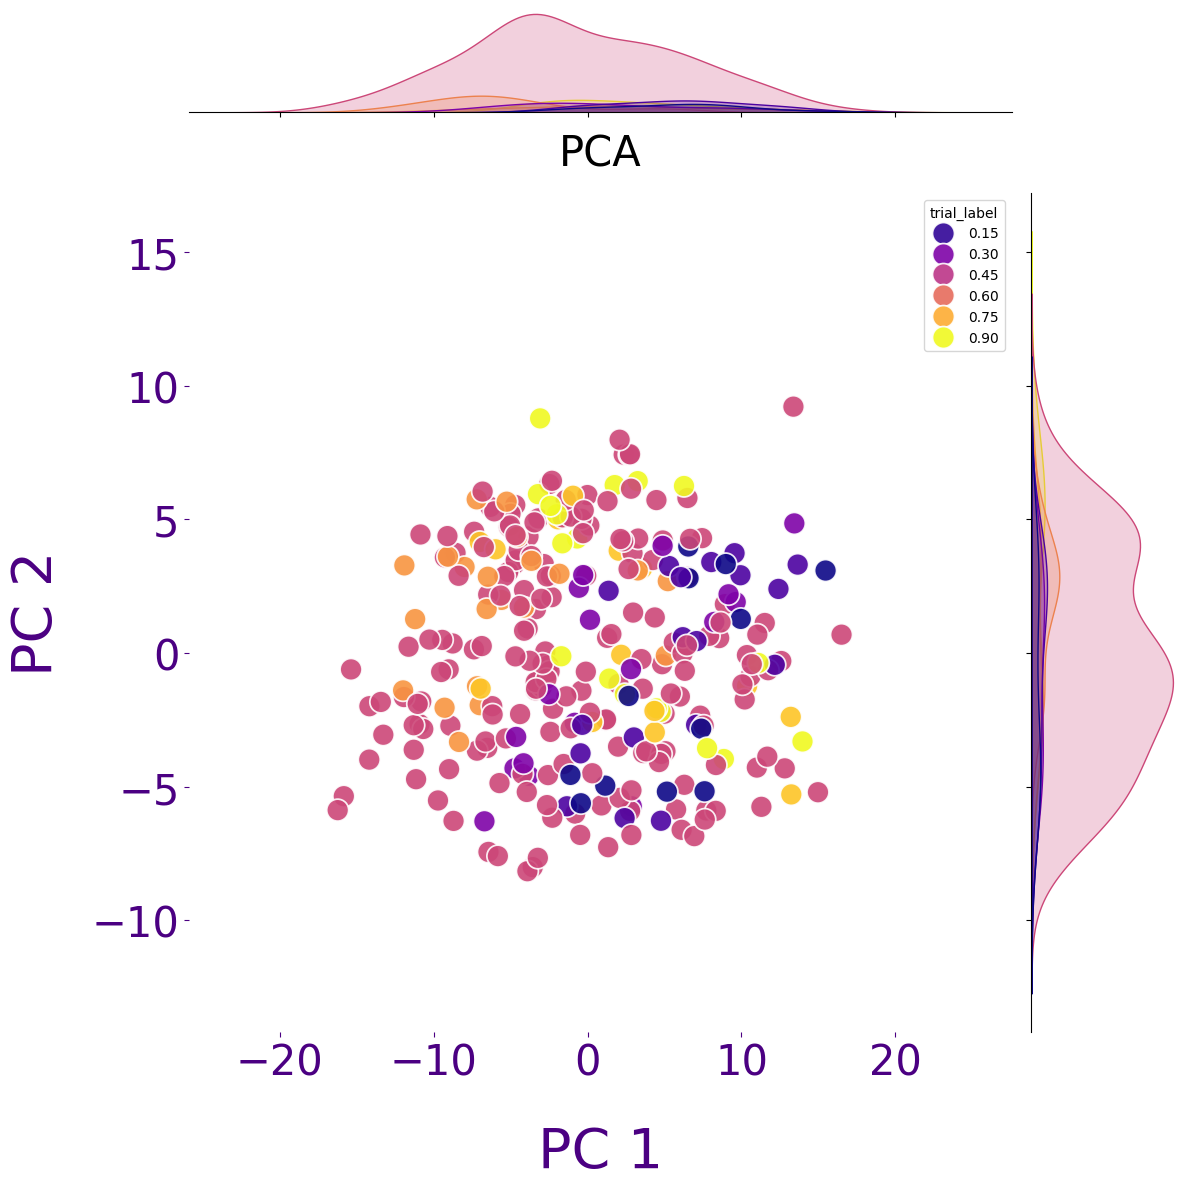

In [5]:
fing = 0
neural_data_trial_avg, trial_labels = compute_trial_averages(neural_data, trials.flatten(), trial_labels = targ[:,fing].flatten())

fit_pca_and_plot_scatter(feature_array = neural_data_trial_avg, trial_labels = trial_labels, scale_features_TF=False)


In [6]:
neural_data_trial_avg.shape

(293, 96)

In [9]:
import numpy as np
np.unique(trial_labels)

array([0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9], dtype=float32)

Plot kinematic target locations

---



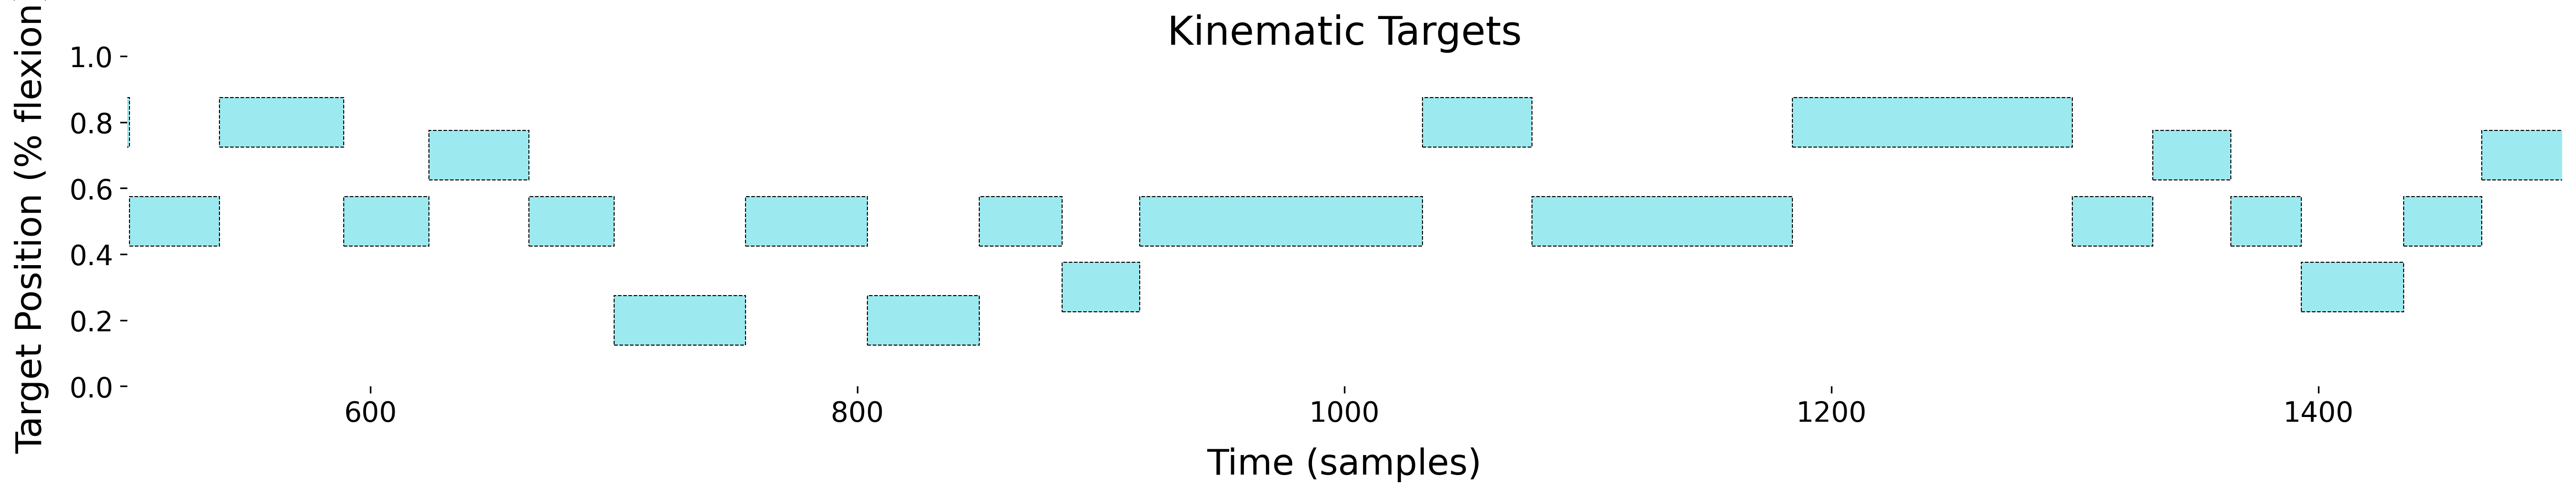

In [10]:
def plot_targets(targ, fing_color, targ_radius = 0.075, x_lim=(0,len(targ)),y_pred=None, plot_targ_TF=False):

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd

  # Find transitions in target display
  targ_starts = np.concatenate(([0], np.where(np.diff(targ) != 0)[0] + 1))

  # Compute the duration (W) of each target
  targ_durations = np.diff(np.append(targ_starts, len(targ)))  # Ensuring last target is included

  # Compute target heights
  # targ_half_height = targsize[targ_starts].flatten()  # Select correct column
  targ_height = 2 * targ_radius  # Full height = 2 * R
  targ_locs = targ[targ_starts] - targ_radius  # Compute Y positions

  # Plot the targets as rectangles
  fig, ax = plt.subplots(figsize=(22, 3), dpi=300)
  if plot_targ_TF:
    ax.plot(range(len(targ)), targ, 'k', linewidth=0.5, linestyle='--', zorder=1)  # Plot the target trajectory

  # Draw rectangles
  for i in range(len(targ_starts)):
      rect = plt.Rectangle((targ_starts[i], targ_locs[i]),
                          targ_durations[i], targ_height,
                          edgecolor='k', facecolor=fing_color,
                          alpha=1, linestyle='--', linewidth=0.5, zorder=2)
      ax.add_patch(rect)

  if y_pred is not None:
    ax.plot(range(len(y_pred)), y_pred, 'b', linewidth=1, linestyle='-', zorder=3)  # Plot the target trajectory

  ax.spines[:].set_visible(False)

  ax.set_xlim(x_lim[0], x_lim[-1])

  # Configure plot
  ax.set_xlabel('Time (samples)',fontsize=18,labelpad=10)
  ax.set_ylabel('Target Position (% flexion)',fontsize=18,labelpad=10)
  ax.set_title('Kinematic Targets',fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.grid(False)
  plt.show()

fing = 0  # select finger to plot
fing_color = '#9CEAEF' if fing == 0 else '#F4C343' if fing == 1 else 'k'
plot_targets(targ[:, fing], targ_radius=targsize.mean(), fing_color = fing_color, x_lim=(500,1500), plot_targ_TF=False)


Format Input (neural data)

In [ ]:
#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=neural_data


Format Output (kinematic target data)

In [ ]:

#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (for this dataset)
#But using them all as covariates helps performance

#We will now determine position
pos_binned=np.zeros(vels_binned.shape) #Initialize
pos_binned[0,:]=0 #Assume starting position is at [0,0]
#Loop through time bins and determine positions based on the velocities
for i in range(pos_binned.shape[0]-1):
    pos_binned[i+1,0]=pos_binned[i,0]+vels_binned[i,0]*.05 #Note that .05 is the length of the time bin
    pos_binned[i+1,1]=pos_binned[i,1]+vels_binned[i,1]*.05

#We will now determine acceleration
temp=np.diff(vels_binned,axis=0) #The acceleration is the difference in velocities across time bins
acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0) #Assume acceleration at last time point is same as 2nd to last

#The final output covariates include position, velocity, and acceleration
y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)


Implement lagging

In [ ]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]


Train-test split

In [ ]:
# Split all data into train and test
X_kf_train, X_kf_test, y_kf_train, y_kf_test = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=42)


Preprocessing: Scaling and Mean Subtraction

In [ ]:
X_preprocessor = StandardScaler() # Z-score neural data
y_preprocessor = StandardScaler(with_std=False) # Zero-center target data

# Apply preprocessing to neural data
X_kf_train = X_preprocessor.fit_transform(X_kf_train)
X_kf_test  = X_preprocessor.transform(X_kf_test)

# Apply preprocessing to target data
y_kf_train = y_preprocessor.fit_transform(y_kf_train)
y_kf_test  = y_preprocessor.transform(y_kf_test)


Train-val split (optional)

In [ ]:
# Split train data into train and validation sets

# X_kf_train, X_kf_valid, y_kf_train, y_kf_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=42)


Run Kalman Filter

---



In [3]:
# Initialize filter
model_kf = KalmanFilterDecoder_PIS(C=1) # Kalman filter with precomputed initial state. (Initial state computed during training)

# Fit model
model_kf.fit(X_kf_train,y_kf_train)

y_pred_kf_train = model.predict(X_kf_train)
y_pred_kf_test  = model.predict(X_kf_test)


NameError: name 'X_kf_train' is not defined

In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_kf_train, y_pred_kf_train))
test_rmse  = np.sqrt(mean_squared_error(y_kf_test, y_pred_kf_test))
train_r2   = r2_score(y_kf_train, y_pred_kf_train)
test_r2    = r2_score(y_kf_test, y_pred_kf_test)

from IPython.display import clear_output
# clear_output()

print(f"----------- PERFORMANCE METRICS: TRAINING SET ---------------")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET ---------------")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

fing = 0
X = neural_data.copy()
y = targ[:, fing]

preprocessor = num_pipeline = Pipeline(
    steps = [('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())]
)

# model = Ridge(alpha=0.001, max_iter=1000)
model = XGBRegressor(n_estimators=100, max_depth=2, subsample=1,
                     colsample_bytree=0.1, min_child_weight = 20, eval_metric  = mean_squared_error,early_stopping_rounds=10)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# train_idx = np.round(X.shape[0]*0.8).astype(int)
# X_train = X[:train_idx]
# y_train = y[:train_idx]
# X_test  = X[train_idx:]
# y_test  = y[train_idx:]

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

# train_idx = np.round(X_train.shape[0]*0.8).astype(int)
# X_val = X_train[train_idx:]
# y_val = y_train[train_idx:]
# X_train  = X_train[:train_idx]
# y_train  = y_train[:train_idx]

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)

# --------------- Evaluate model performance ----------------
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2   = r2_score(y_train, y_pred_train)
test_r2    = r2_score(y_test, y_pred_test)

from IPython.display import clear_output
# clear_output()

print(f"----------- PERFORMANCE METRICS: TRAINING SET ---------------")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET ---------------")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET ---------------
Train RMSE: 0.1736
Train R²: 0.3004
----------- PERFORMANCE METRICS: TEST SET ---------------
Test RMSE: 0.2008
Test R²: 0.0505


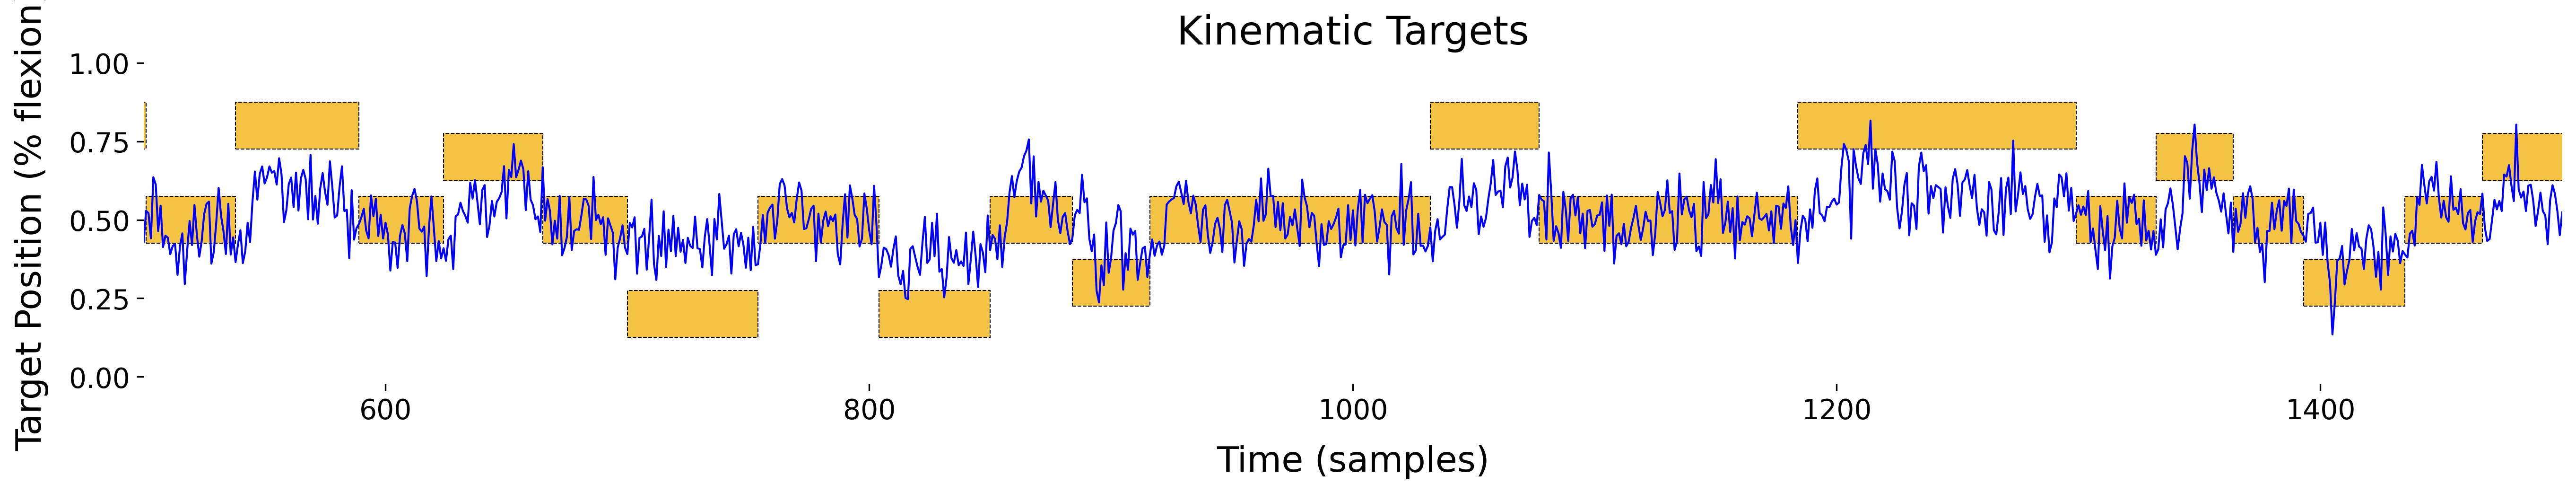

In [14]:
# fing = 1  # select finger to plot
# fing_color = '#9CEAEF' if fing == 0 else '#F4C343' if fing == 1 else 'k'
# plot_targets(y_train, targsize, fing_color, y_pred = y_pred_train, x_lim=(0,1200))

fing = 1  # select finger to plot
fing_color = '#9CEAEF' if fing == 0 else '#F4C343' if fing == 1 else 'k'
plot_targets(targ = y_train, y_pred = y_pred_train, targ_radius=targsize.mean(), fing_color = fing_color, x_lim=(500,1500))


In [16]:
np.unique(y_train)

array([0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9], dtype=float32)